In [1]:
import numpy as np
import pyclesperanto_prototype as cle
from skimage.data import cells3d
from skimage.segmentation import morphological_chan_vese
import timeit
cle.select_device()

<Intel(R) Iris(TM) Plus Graphics on Platform: Apple (2 refs)>

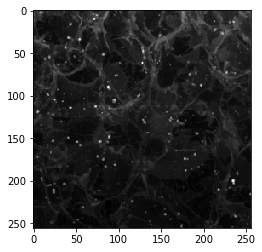

(60, 256, 256)


In [2]:
image = cells3d()[:,0,...]
cle.imshow(image)
print(image.shape)

In [3]:
def level_set_gpu():
    result_gpu = cle.morphological_snakes(image, n_iter=50, smoothing=0)
 
def level_set_cpu():
    result_cpu = morphological_chan_vese(image, iterations=50, smoothing=0)

In [4]:
time_in_s = timeit.timeit(level_set_gpu, number=10)
print("GPU time = ", time_in_s)

GPU time =  51.594847822


In [5]:
time_in_s = timeit.timeit(level_set_cpu, number=10)
print("CPU time = ", time_in_s)

CPU time =  87.60801198099999


In [9]:
image2d = cells3d()[30,0,...]

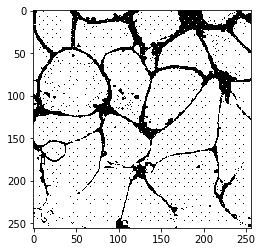

In [10]:
result_gpu = cle.morphological_snakes(image2d, n_iter=50, smoothing=0)
cle.imshow(result_gpu)

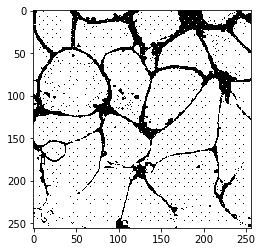

In [11]:
result_cpu = morphological_chan_vese(image2d, iterations=50, smoothing=0)
cle.imshow(result_cpu)